In [1]:
import numpy as np
import pandas as pd

import os
import glob
import librosa
import tqdm
import pickle
import time

from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torch

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import utils
from flame import Trainer

sns.set()

DATA_PATH = './data'
join_path = lambda path: os.path.join(DATA_PATH, path)

In [2]:
with open(join_path('train_mels.pkl'), 'rb+') as f:
    train_X = pickle.load(f)
    
with open(join_path('val_mels.pkl'), 'rb+') as f:
    val_X = pickle.load(f)
    
train_y = np.load(join_path('train_targets.npy'))
val_y = np.load(join_path('val_targets.npy'))

In [3]:
train_ds = utils.create_ds(train_X, train_y)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = utils.create_ds(val_X, val_y)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [6]:
class GRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=64,
            num_layers=3,
            dropout=0.2,
            bias=True,
            batch_first=True,
            bidirectional=True
        )
        self.clf = nn.Linear(384, 80)
    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)
        seq, h = self.gru(x)
        h = h.permute(1, 0, 2)
        h = h.contiguous().view(h.size(0), -1)
        h = self.clf(h)
        return h

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

model = GRUModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logdir = join_path('ModifiedDCNN_logdir')

trainer = Trainer(model, optimizer, criterion, device, logdir)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=True
)

In [8]:
losses, best_loss, epoch_time = utils.train_model(trainer, train_dl, val_dl, val_y, scheduler,
                                            n_epochs=1000, gap=20, verbose=True)

Epoch, best_val_lwlrap
   1, 0.0969
   2, 0.1225
   3, 0.1769
   4, 0.1998
   6, 0.2297
   7, 0.2448
   8, 0.2756
   9, 0.2843
  11, 0.3074
  13, 0.3212
  14, 0.3310
  15, 0.3407
  16, 0.3434
  17, 0.3593
  19, 0.3597
  20, 0.3625
  21, 0.3806
  25, 0.3965
  29, 0.4054
  35, 0.4151
  40, 0.4313
  48, 0.4445
Epoch    59: reducing learning rate of group 0 to 5.0000e-04.
  60, 0.4512
  63, 0.4529
  68, 0.4614
  72, 0.4639
Epoch    83: reducing learning rate of group 0 to 2.5000e-04.
Done.


In [9]:
epoch_time, best_loss

(2.1434861266094707, 0.46393132036167517)

Text(0.5, 1.0, 'Logloss')

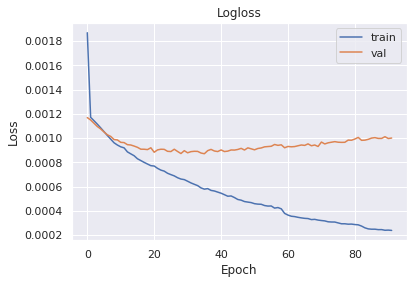

In [10]:
plt.plot(losses['train']['logloss'])
plt.plot(losses['val']['logloss'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Logloss')

Text(0.5, 1.0, 'Lwlrap')

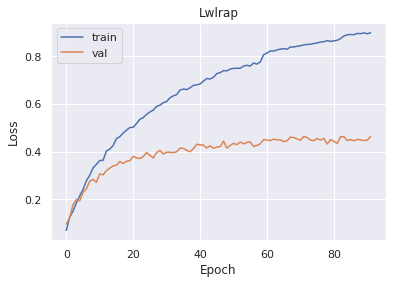

In [11]:
plt.plot(losses['train']['lwlrap'])
plt.plot(losses['val']['lwlrap'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Lwlrap')

In [12]:
with open(join_path('GRU_losses.pkl'), 'wb+') as f:
    pickle.dump(losses, f)